In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import numpy as np
from dataset import *

from torch.utils.tensorboard import SummaryWriter

In [7]:
root_dir = "/home/gc28692/Projects/data/nvgesture/nvGesture_v1"

In [8]:
tsfms = transforms.Compose([
    transforms.ToTensor()
    ]
)
dataset = Gestures(root_dir,tsfms,train=True)
train_set, val_set = torch.utils.data.random_split(dataset, [950, 100])
train_loader = DataLoader(train_set,batch_size=32)
val_loader = DataLoader(val_set,batch_size=32)
loss_fn = torch.nn.CrossEntropyLoss()

In [9]:
# Create RNN Model
class RNNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        # self.rnn = torch.nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        # Readout layer
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to('cuda')
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to('cuda')
            
        # One time step
        out, (hn,cn) = self.rnn(x, (h0,c0))
        out = self.fc(out[:, -1, :]) 
        return out

In [10]:
model = RNNModel(63,512,1,25)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [11]:
import time
writer = SummaryWriter("runs")
# create model, optimizer, and loss
gest_net = model.to('cuda')

losses = []
# epoch loop
b_i = 0
for e in range(100):
    print(f"========== Training Epoch {e} ==========")
    i = 0
    # batch loop
    for img,target in train_loader:
        img,target = img.to('cuda'),target.to('cuda')
        optimizer.zero_grad()

        # forward pass
        out = gest_net(img)
        # print(torch.argmax(out,dim=1))
        loss = loss_fn(out,target)
        writer.add_scalar("Metric/train",loss,b_i)
        # print(loss.item())
        if i % 10 == 0:
            print(f'Epoch {e}, batch ({i}/{len(train_loader)}), train loss: {loss}')
        losses.append(loss)

        # backward pass
        loss.backward()
        optimizer.step()
        i += 1
        b_i += 1
    # validation at the end of training
    i = 0
    val_loss = 0
    num_correct = 0
    total = 0
    print(f"========== Validation ==========")
    for idx, (img,target) in enumerate(val_loader):
        img,target = img.to('cuda'),target.to('cuda')
        with torch.no_grad():
            out = gest_net(img)
            val_loss += loss_fn(out,target)
            num_correct += sum(torch.argmax(out,dim=1) == target)
            total += len(target)
            i += 1
    print(f"Avg Val Loss: {val_loss/i}, Avg Val Acc: {num_correct/total}")
    writer.add_scalar("Metric/val",num_correct/total, e)

2023-03-23 22:29:04.502247: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


========== Training Epoch 0 ==========
Epoch 0, batch (0/30), train loss: 3.214484453201294
Epoch 0, batch (10/30), train loss: 3.2398409843444824
Epoch 0, batch (20/30), train loss: 3.1677656173706055
========== Validation ==========
Avg Val Loss: 3.217846632003784, Avg Val Acc: 0.08999999612569809
========== Training Epoch 1 ==========
Epoch 1, batch (0/30), train loss: 3.01519513130188
Epoch 1, batch (10/30), train loss: 2.9283013343811035
Epoch 1, batch (20/30), train loss: 2.9700071811676025
========== Validation ==========
Avg Val Loss: 3.0466859340667725, Avg Val Acc: 0.14000000059604645
========== Training Epoch 2 ==========
Epoch 2, batch (0/30), train loss: 2.7847838401794434
Epoch 2, batch (10/30), train loss: 2.6962671279907227
Epoch 2, batch (20/30), train loss: 2.8457958698272705
========== Validation ==========
Avg Val Loss: 3.245311737060547, Avg Val Acc: 0.07999999821186066
========== Training Epoch 3 ==========
Epoch 3, batch (0/30), train loss: 2.862387180328369
Epoc

KeyboardInterrupt: 

In [12]:
test_set = Gestures(root_dir,tsfms,train=False,test=True)
test_loader = DataLoader(test_set,batch_size=32)

i = 0
num_correct = 0
total = 0
print(f"========== test ==========")
preds = torch.zeros(len(test_loader.dataset))
gt = torch.zeros(len(test_loader.dataset))
for idx, (img,target) in enumerate(test_loader):
    img,target = img.to('cuda'),target.to('cuda')
    with torch.no_grad():
        out = gest_net(img)
        num_correct += sum(torch.argmax(out,dim=1) == target)
        total += len(target)
        i += 1
        preds[idx*test_loader.batch_size:idx*test_loader.batch_size+len(target)] = torch.argmax(out,dim=1)
        gt[idx*test_loader.batch_size:idx*test_loader.batch_size+len(target)] = target
print(f"Avg Test Acc: {num_correct/total}")

========== test ==========
Avg Test Acc: 0.21161827445030212


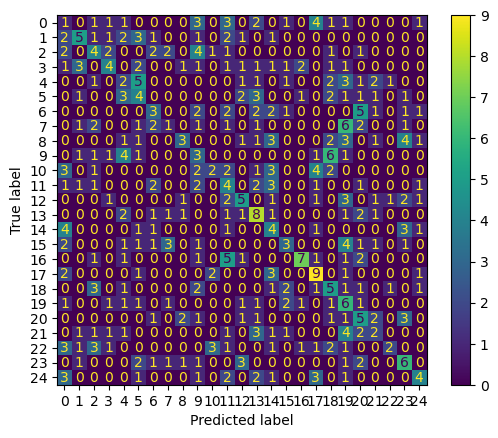

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(gt, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()